In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

In [3]:
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
]

classifiers = [
    LogisticRegression(fit_intercept=False, max_iter=10000, C=1e9),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
]

In [9]:
df = pd.read_csv("Credit.csv")
df = df.drop(columns=['Unnamed: 0'])

# Add indicator variable if income > 50
df['Rich'] = 0
df.loc[df['Income'] > 50, 'Rich'] = 1

In [10]:
y_r1, X_r1 = dmatrices('Rich ~ Balance + Limit', data=df, return_type='dataframe')
y_r2, X_r2 = dmatrices('Rich ~ Rating + Limit', data=df, return_type='dataframe')
y_c1, X_c1 = dmatrices('Cards ~ Balance + Limit', data=df, return_type='dataframe')
y_c2, X_c2 = dmatrices('Cards ~ Balance + Income', data=df, return_type='dataframe')

datasets = [
    (X_r2[['Rating','Limit']].to_numpy(), y_r2['Rich'].to_numpy()),
    (X_r1[['Balance','Limit']].to_numpy(), y_r1['Rich'].to_numpy()),
    (X_c1[['Balance','Limit']].to_numpy(), y_c2['Cards'].to_numpy()),
    (X_c2[['Balance','Income']].to_numpy(), y_c2['Cards'].to_numpy()),
]

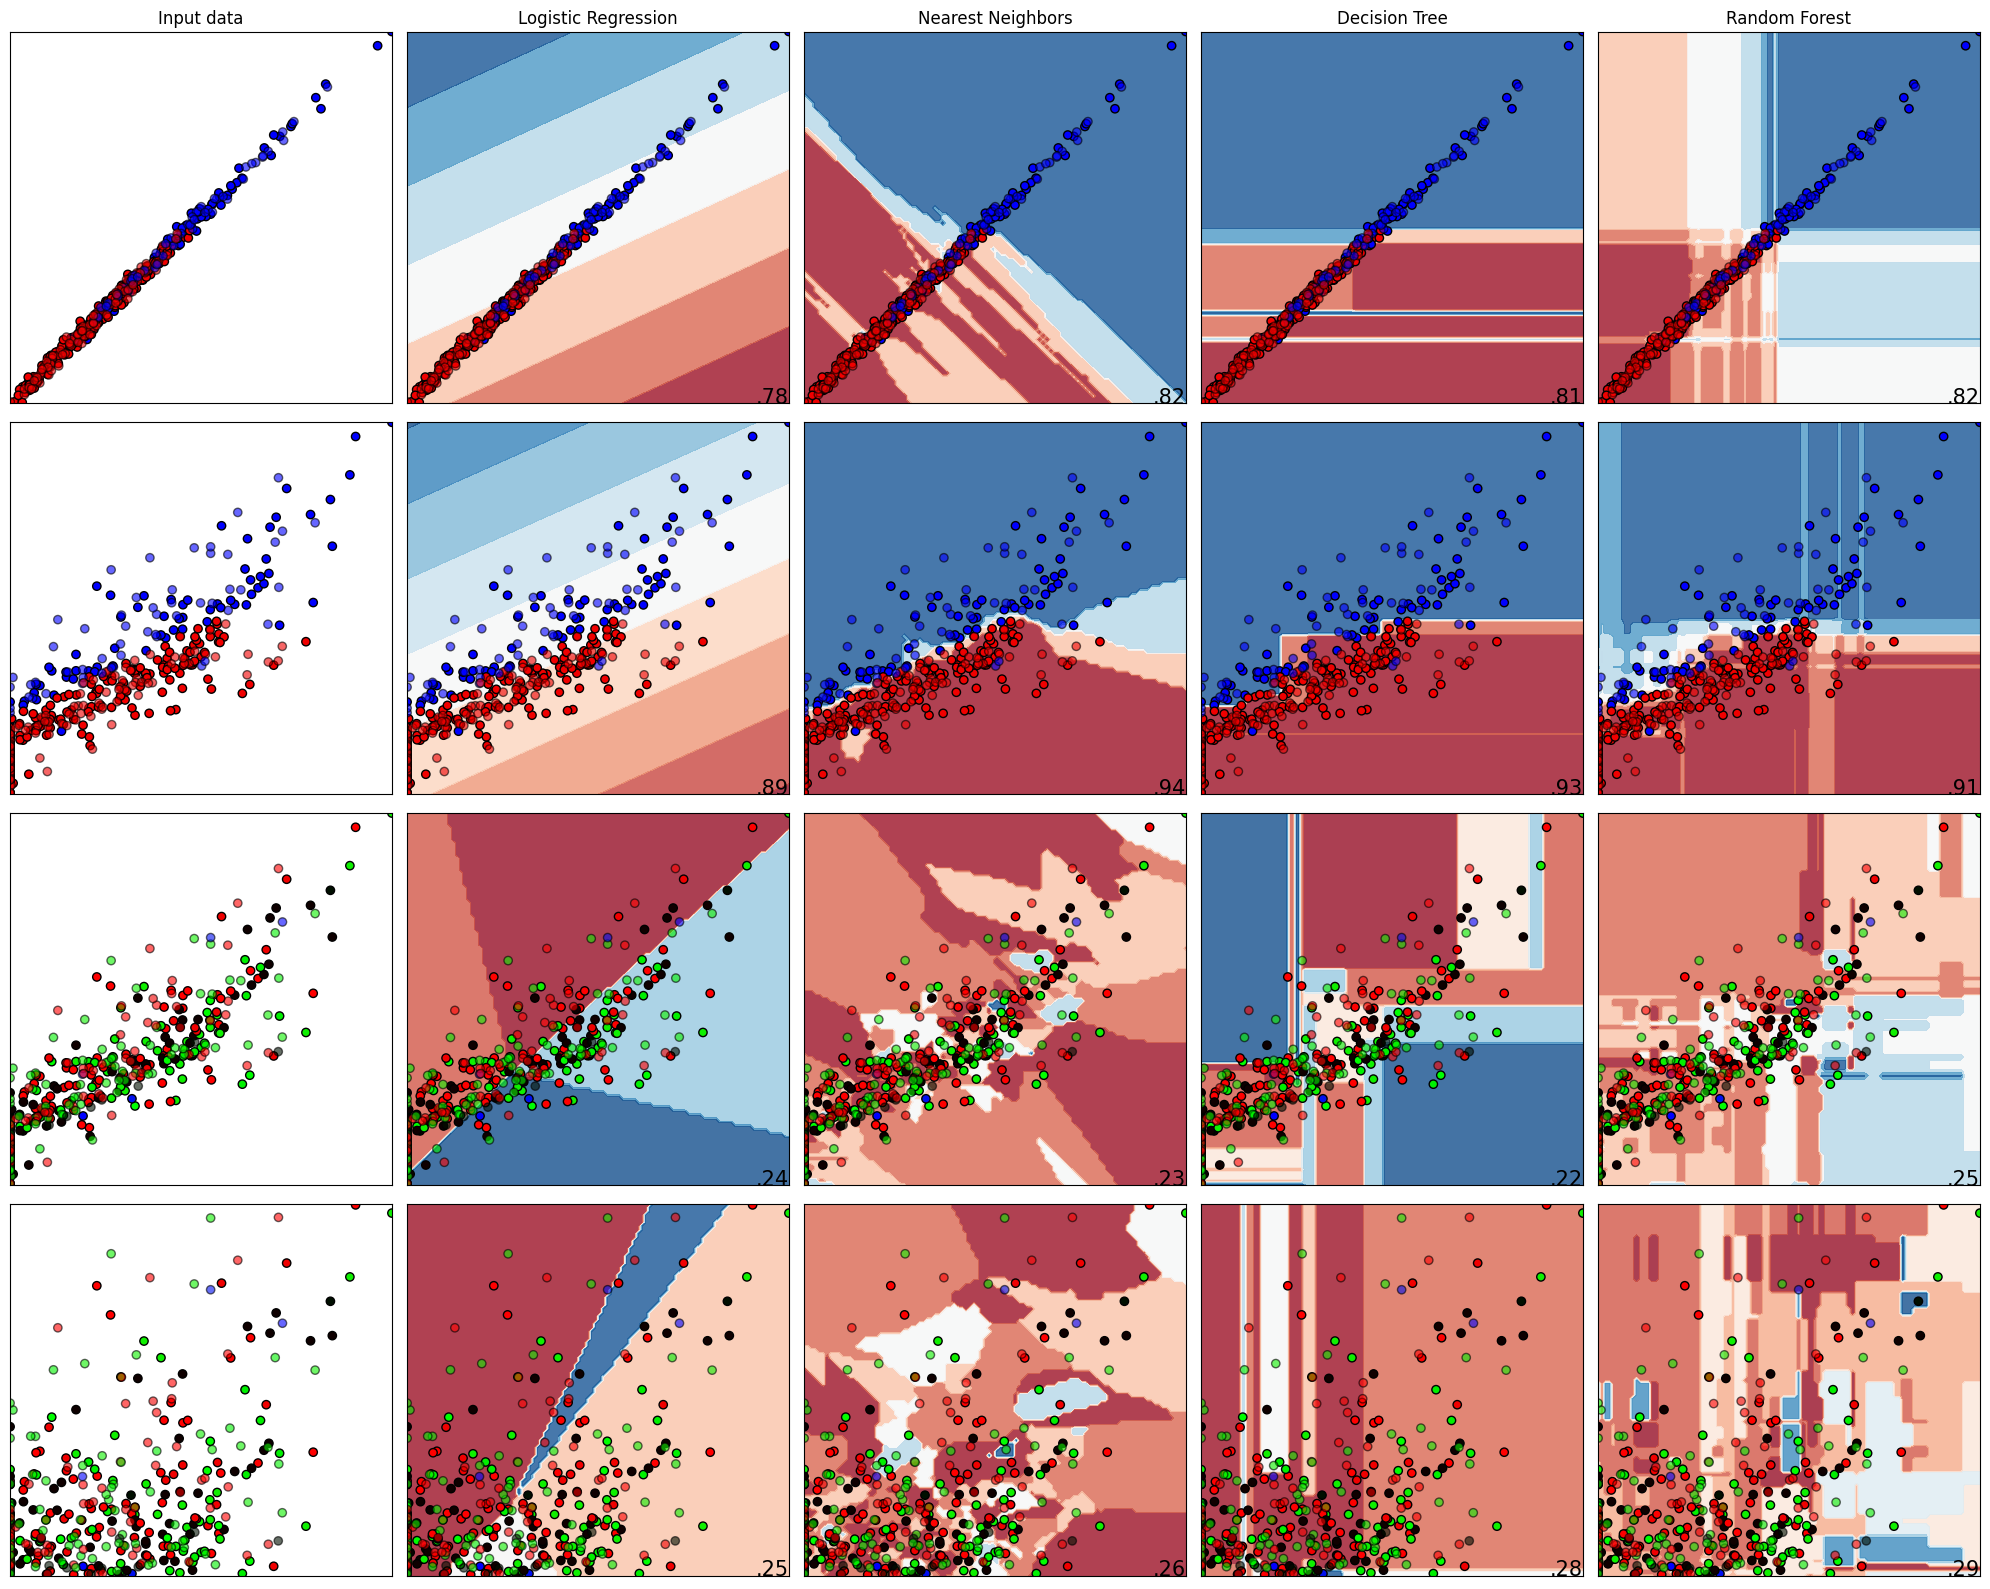

In [11]:
figure = plt.figure(figsize=(20, 16))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#F00000", "#FF0000", "#0F0000","#0FF000", "#00F000", "#00FF00","#000F00", "#000FF0", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()